# GIMVI analysis

Supplemental analysis showing limited generalization of TISSUE to the gimVI model (currently, does not generally work on all datasets due to exploding gradients bug in gimVI).

It relies on the outputs of `spatial_conformal_uncertainty.py` followed by `get_calibration.py` and also `get_score_for_dataset.py` applied to Dataset11 (only dataset that works with gimVI as of August 2023). In particular, it requires running the Python commands in `run_conformal_11_gimvi.slurm` and `run_scores_11_gimvi.slurm`. The h5ad anndata objects and pickle files should be saved into "scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/" with respect to the current working directory (or an alternative path for stratified grouping results).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import scanpy as sc
from scipy.stats import pearsonr, spearmanr
import anndata as ad
import seaborn as sns
import pickle

from TISSUE.tissue.main import *
from TISSUE.tissue.experiments import measure_calibration_error

In [2]:
#### Swap dataset names to real identifiers
dataset_mapper = {"Dataset3": "Mouse Hipp.\n(seqFISH)",
                  "Dataset9": "Mouse VISP\n(MERFISH)",
                  "Dataset11": "Mouse PC\n(STARmap)", 
                  "Dataset12": "Human MTG\n(ISS)",
                  "Dataset13": "Mouse VISP\n(ISS)",
                  "Dataset14": "Drosophila Embryo\n(FISH)",
                  "Dataset15": "Mouse SC\n(osmFISH)",
                  "Dataset17": "Mouse VISP\n(ExSeq)",
                  "Axolotl": "Axolotl Brain\n(Stereo-seq)",
                  "Dataset7": "Human U2OS\n(MERFISH)",
                  "Dataset1": "Mouse Gast.\n(seqFISH)"}

method_mapper = {"tangram": "Tangram",
                 "spage": "SpaGE",
                 "knn": "Harmony",
                 "gimvi": "gimVI"}
#### 

## gimVI prediction performance

Collecting prediction performance metrics for one dataset using the output h5ad of `spatial_conformal_uncertainty.py` with gimVI set to the model (requires GPU) followed by `get_calibration.py`.

In [3]:
datasets = ["Dataset11"]
methods = ['gimvi']

dataset_col = []
method_col = []
R_col = []
Spearman_col = []
MAE_col = []


for d in datasets:
    adata = sc.read_h5ad("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_gimvi_SCPI.h5ad")
    n_cells = adata.shape[0]
    n_genes = adata.shape[1]
    
    # loop methods
    for method in methods:
        
        imputed = np.array(adata.obsm[method+"_predicted_expression"])
        actual = adata[:,adata.obsm[method+"_predicted_expression"].columns].X
        
        # loop genes
        for j in range(adata.obsm[method+"_predicted_expression"].shape[1]):
            not_nans = (~np.isnan(imputed[:,j]) & ~np.isnan(actual[:,j]))
            
            # compute stats
            r, p = pearsonr(imputed[not_nans,j], actual[not_nans,j])
            rho, p = spearmanr(imputed[:,j], actual[:,j])
            mae = np.nanmean(np.abs(imputed[:,j]-actual[:,j]))
            
            name = dataset_mapper[d]
            
            # append stats
            dataset_col.append(name+f"\nn={n_cells}\np={n_genes}") # add n_cell/n_gene info
            method_col.append(method_mapper[method])
            R_col.append(r)
            Spearman_col.append(rho)
            MAE_col.append(mae)

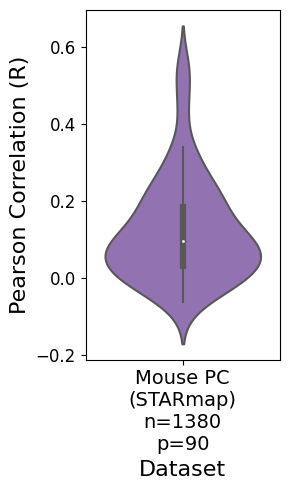

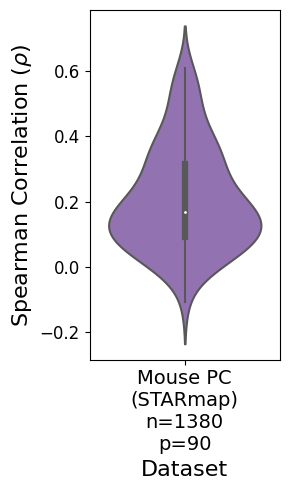

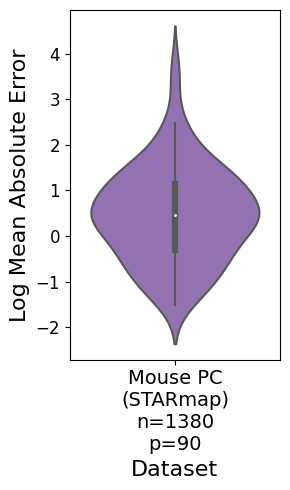

In [4]:
# Generate violin plots of Spearman, Pearson, and MAE performance metrics

# Initialize dataframe
df = pd.DataFrame([])
df["Dataset"] = dataset_col
df["Method"] = method_col
df["Pearson"] = R_col
df["Spearman"] = Spearman_col
df["MAE"] = MAE_col
df["MAE"] = df["MAE"].astype(float)
df["log MAE"] = np.log(df["MAE"])


# Pearson
plt.figure(figsize=(3,5))
sns.violinplot(x="Dataset", y="Pearson", color="tab:purple", data=df)
plt.xlabel("Dataset", fontsize=16)
plt.ylabel("Pearson Correlation (R)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('plots/scpi_datasets/gimvi_violin_performance_pearson.pdf', dpi=300, bbox_inches='tight')
plt.show()


# Spearman
plt.figure(figsize=(3,5))
sns.violinplot(x="Dataset", y="Spearman", color="tab:purple", data=df)
plt.xlabel("Dataset", fontsize=16)
plt.ylabel(r"Spearman Correlation ($\rho$)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('plots/scpi_datasets/gimvi_violin_performance_spearman.pdf', dpi=300, bbox_inches='tight')
plt.show()


# MAE
plt.figure(figsize=(3,5))
sns.violinplot(x="Dataset", y="log MAE", color="tab:purple", data=df)
plt.xlabel("Dataset", fontsize=16)
plt.ylabel("Log Mean Absolute Error", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('plots/scpi_datasets/gimvi_violin_performance_logmae.pdf', dpi=300, bbox_inches='tight')
plt.show()

## TISSUE calibration performance

Collecting calibration performance from pickel file output of `get_calibration.py`

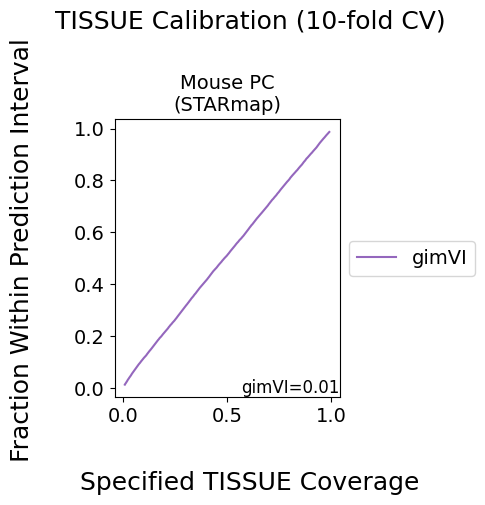

In [5]:
# Generate calibration plot for all genes averaged together
dataset_names = ["Dataset11"]
colors = ["tab:purple"]

fig, axs = plt.subplots(nrows=1, ncols=len(dataset_names), sharex=True, sharey=True, figsize=(5, 5))
for i, dataset_name in enumerate(dataset_names):
    pickleFile = open("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+dataset_name+"_conformal_dict_gimvi.pkl", 'rb')
    res_dict = pickle.load(pickleFile)

    for ki, key in enumerate(res_dict.keys()):
        axs.plot(res_dict[key]['1-alpha'], res_dict[key]['test'], linewidth=1.5, label=method_mapper[key], color=colors[ki])
        error = round(measure_calibration_error(res_dict, key),2)
        axs.annotate(method_mapper[key]+"="+str(error), xy=(1, 0+(ki*0.05)), xycoords='axes fraction', fontsize=12, horizontalalignment='right', verticalalignment='bottom')
    
    axs.set_title(dataset_mapper[dataset_name], fontsize=14)
    axs.tick_params(axis='both', which='major', labelsize=14)
    axs.tick_params(axis='both', which='minor', labelsize=14)
    
fig.suptitle("TISSUE Calibration (10-fold CV)", fontsize=18)
fig.supxlabel("Specified TISSUE Coverage", fontsize=18)
fig.supylabel("Fraction Within Prediction Interval", fontsize=18)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14, ncol=1)
plt.tight_layout(pad=1.8)
plt.savefig('plots/scpi_calibration/gimvi_REVISED_paneled_AVG_calibration_curves.pdf')
plt.show()

## Correlation between gimVI error and cell-centric variability

0.5256236610328612
0.3943479141219428


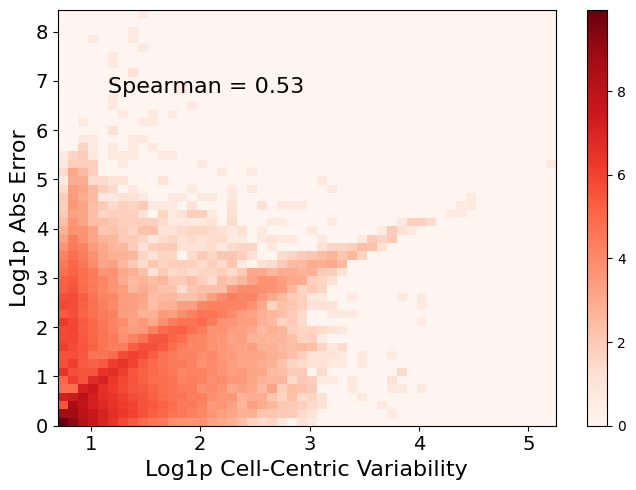

In [6]:
# combined into one plot

datasets = ["Dataset11"]
methods = ['gimvi']


dataset_col = []
method_col = []
uncertainty_col = []
abs_error_col = []


for i, d in enumerate(datasets):
    adata = sc.read_h5ad("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_gimvi_NOCV.h5ad")
    n_cells = adata.shape[0]
    n_genes = adata.shape[1]
    
    for j, method in enumerate(methods):
        
        # get uncertainties, errors matched
        genes = adata.var_names
        uncertainties = adata.obsm[method+"_predicted_expression_uncertainty"][genes]
        errs = np.abs(adata.obsm[method+"_predicted_expression"][genes]-adata.X)
        uncertainties = np.array(uncertainties).flatten()
        errs = np.array(errs).flatten()
        
        # append results
        dataset_col.append([d]*len(uncertainties))
        method_col.append([method]*len(uncertainties))
        uncertainty_col.append(uncertainties)
        abs_error_col.append(errs)

        
dataset_col = np.concatenate(dataset_col)
method_col = np.concatenate(method_col)
uncertainty_col = np.concatenate(uncertainty_col)
abs_error_col = np.concatenate(abs_error_col)

# Make dataframe
df = pd.DataFrame([])
df["Dataset"] = dataset_col
df["Method"] = method_col
df["Error"] = abs_error_col
df["Uncertainty"] = uncertainty_col


# Make Plot
x = np.log1p(df["Uncertainty"])
y = np.log1p(df["Error"])

rho, p = spearmanr(x, y)
r, p = pearsonr(x, y)
print(rho)
print(r)

plt.figure(figsize=(7,5))
heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(np.log1p(heatmap).T, extent=extent, origin='lower', cmap='Reds', aspect='auto')
plt.annotate("Spearman = "+str(round(rho,2)), (0.1,0.8), xycoords="axes fraction", fontsize=16)
plt.colorbar()
plt.xlabel("Log1p Cell-Centric Variability", fontsize=16)
plt.ylabel("Log1p Abs Error", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(f'plots/scpi_datasets/gimvi_REVISED_uncertainty_error_correlations_log_COMBINED.pdf', bbox_inches='tight')
plt.show()

## Correlation between gimVI error and TISSUE PI width

0.5853684585929054
0.4425579436270139


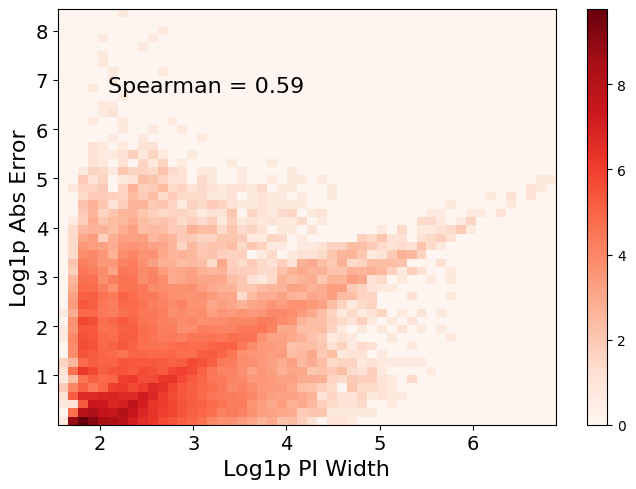

In [7]:
# CELL x GENE level

pi_width = 67

methods = ['gimvi']
datasets = ["Dataset11"]


all_uppers = np.array([])
all_lowers = np.array([])
all_predicteds = np.array([])
all_maes = np.array([])
all_datasets = np.array([])
all_models = np.array([])

for d in datasets:
    adata = sc.read_h5ad("scg_results/scpi/2023Aug1_kautokauto_SDbasedCCPplus1/"+d+"_gimvi_SCPI.h5ad")
    
    # compute stacked bandwidth matrices and stacked prediction matrices

    stacked_uppers = []
    stacked_lowers = []
    stacked_predicteds = []
    stacked_maes = []
    stacked_datasets = []
    stacked_models = []
    
    for i, method in enumerate(methods):
        stacked_uppers.append(adata.obsm[method+f"_predicted_expression_hi_{pi_width}"].values)
        stacked_lowers.append(adata.obsm[method+f"_predicted_expression_lo_{pi_width}"].values)
        stacked_predicteds.append(adata.obsm[method+"_predicted_expression"].values)
        stacked_maes.append(np.abs(adata.obsm[method+"_predicted_expression"].values-adata[:,adata.obsm[method+"_predicted_expression"].columns].X))
        stacked_datasets.append(np.full(adata.obsm[method+"_predicted_expression"].shape, d))
        stacked_models.append(np.full(adata.obsm[method+"_predicted_expression"].shape, method))
        
        use_cols = adata.obsm[method+"_predicted_expression"].columns
        use_rows = adata.obsm[method+"_predicted_expression"].index
    
    # append flattened versions
    all_uppers = np.concatenate([all_uppers]+[x.flatten() for x in stacked_uppers])
    all_lowers = np.concatenate([all_lowers]+[x.flatten() for x in stacked_lowers])
    all_predicteds = np.concatenate([all_predicteds]+[x.flatten() for x in stacked_predicteds])
    all_maes = np.concatenate([all_maes]+[x.flatten() for x in stacked_maes])
    all_datasets = np.concatenate([all_datasets]+[x.flatten() for x in stacked_datasets])
    all_models = np.concatenate([all_models]+[x.flatten() for x in stacked_models])
    
# Make Plot
rho, p = spearmanr(np.log1p(all_uppers-all_lowers)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)],
            np.log1p(all_maes)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)])
r, p = pearsonr(np.log1p(all_uppers-all_lowers)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)],
            np.log1p(all_maes)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)])
print(rho)
print(r)

plt.figure(figsize=(7,5))
heatmap, xedges, yedges = np.histogram2d(
    np.log1p(all_uppers-all_lowers)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)],
            np.log1p(all_maes)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)],
            bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(np.log1p(heatmap).T, extent=extent, origin='lower', cmap='Reds', aspect='auto')
plt.annotate("Spearman = "+str(round(rho,2)), (0.1,0.8), xycoords="axes fraction", fontsize=16)
plt.colorbar()
plt.xlabel("Log1p PI Width", fontsize=16)
plt.ylabel("Log1p Abs Error", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('plots/scpi_exploratory/gimvi_REVISED_all_CI_vs_AE_newest_kautokauto.pdf', dpi=300, bbox_inches='tight')
plt.show()